In [14]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from datetime import datetime
import warnings
import matplotlib.dates as mdates
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [2]:
# Import data
path = r"C:\Users\suhas\Documents\cf\ch6\Data\flavors_of_cacao_cleaned.csv"
df = pd.read_csv(path)
df.head()

,Manufacturer,BarName,REF,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,Unknown,Sao Tome
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,Unknown,Togo
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,Unknown,Togo
3,A. Morin,Akata,1680,2015,70.0,France,3.50,Unknown,Togo
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,Unknown,Peru


In [4]:
# Calculate Median Rating for each year
df['MedianRating'] = df.groupby('ReviewDate')['Rating'].transform('median')
df.head()

,Manufacturer,BarName,REF,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin,MedianRating
0,A. Morin,Agua Grande,1876,2016,63.0,France,3.75,Unknown,Sao Tome,3.25
1,A. Morin,Kpime,1676,2015,70.0,France,2.75,Unknown,Togo,3.25
2,A. Morin,Atsane,1676,2015,70.0,France,3.00,Unknown,Togo,3.25
3,A. Morin,Akata,1680,2015,70.0,France,3.50,Unknown,Togo,3.25
4,A. Morin,Quilla,1704,2015,70.0,France,3.50,Unknown,Peru,3.25


In [5]:
# Get relevant columns (ReviewDate and Rating)
df = df[["ReviewDate", 'MedianRating']]
df.head()

,ReviewDate,MedianRating
0,2016,3.25
1,2015,3.25
2,2015,3.25
3,2015,3.25
4,2015,3.25


In [6]:
# Convert to ReviewYear as a datetime object
df['ReviewDate'] = pd.to_datetime(df['ReviewDate'].astype(str), format='%Y')

In [7]:
df.head()

,ReviewDate,MedianRating
0,2016-01-01,3.25
1,2015-01-01,3.25
2,2015-01-01,3.25
3,2015-01-01,3.25
4,2015-01-01,3.25


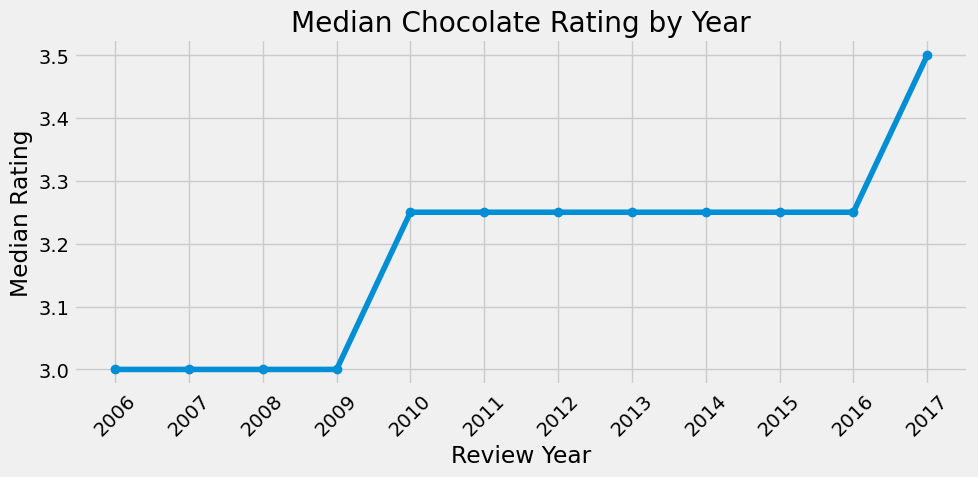

In [13]:
# Drop duplicate ReviewDate + MedianRating pairs
df_unique = df.drop_duplicates(subset=['ReviewDate', 'MedianRating'])

# Sort by date (just in case)
df_unique = df_unique.sort_values('ReviewDate')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_unique['ReviewDate'], df_unique['MedianRating'], marker='o')

# Year-based x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.title('Median Chocolate Rating by Year')
plt.xlabel('Review Year')
plt.ylabel('Median Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

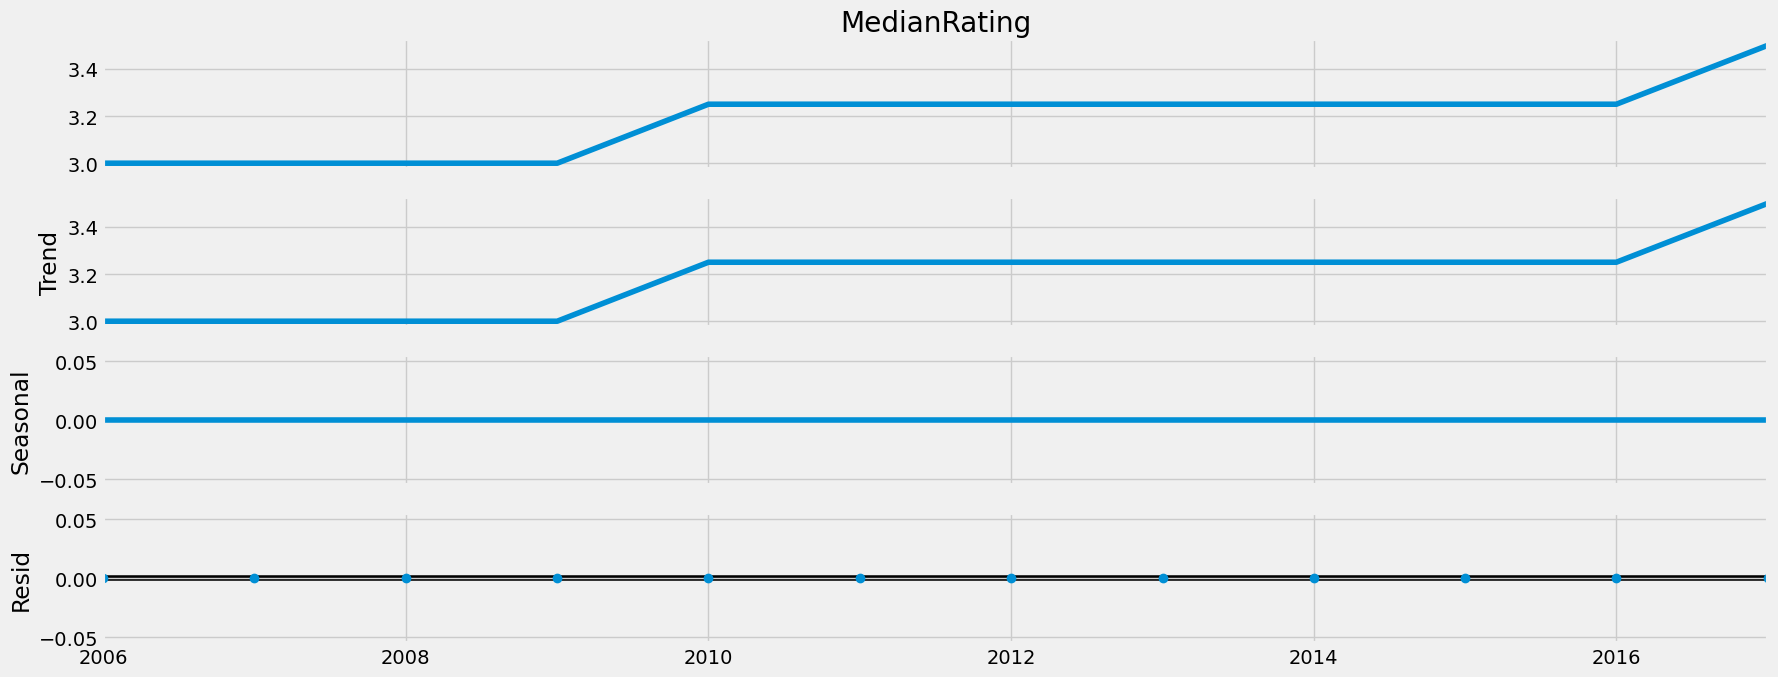

In [23]:
# Set datetime index and frequency
df_unique['ReviewDate'] = pd.to_datetime(df_unique['ReviewDate'])
df_unique = df_unique.set_index('ReviewDate')
df_unique = df_unique.asfreq('YS')  # Year Start frequency


decomposition = sm.tsa.seasonal_decompose(df_unique['MedianRating'], model='additive')
decomposition.plot()
plt.tight_layout()
plt.show()


There appears to be no significant seasonal trend here. In general, the Median Ratings of bars have gone up considerably as the years continue to march on forward.

In [24]:
# Stationarity Test

def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df['MedianRating'])

Dickey-Fuller Stationarity test:
Test Statistic                -1.599483e+01
p-value                        6.609700e-29
Number of Lags Used            0.000000e+00
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


The test statistic (-15.9983) is below the 10% and 5% critical values, and the p-value is under 0.05, indicating a statistically significant result — the data is stationary.

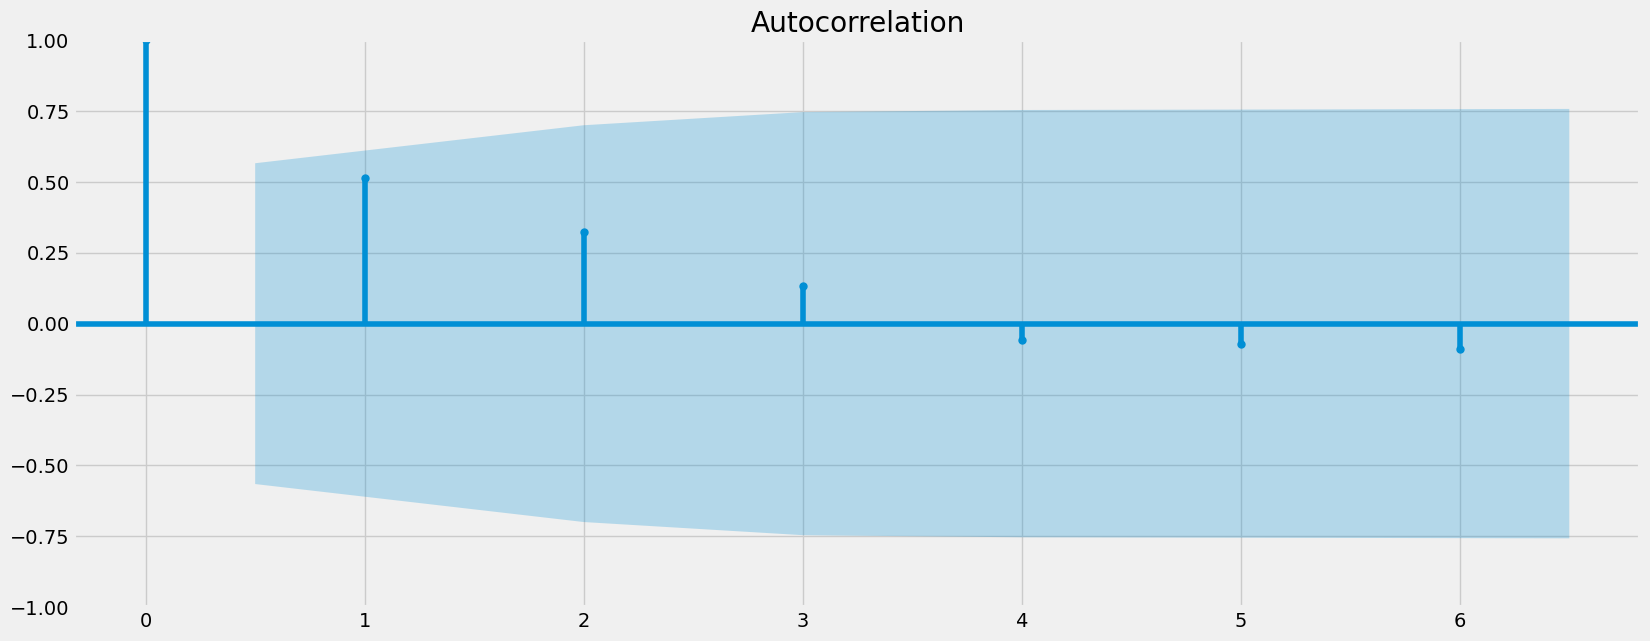

In [26]:
# Autocorrelation plot
plot_acf(df_unique)
plt.show()

There is one lag outside the confidence interval and no major differencing is needed for a minor lag